In [1]:
# reproducing https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset

In [2]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# Loading the data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [4]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


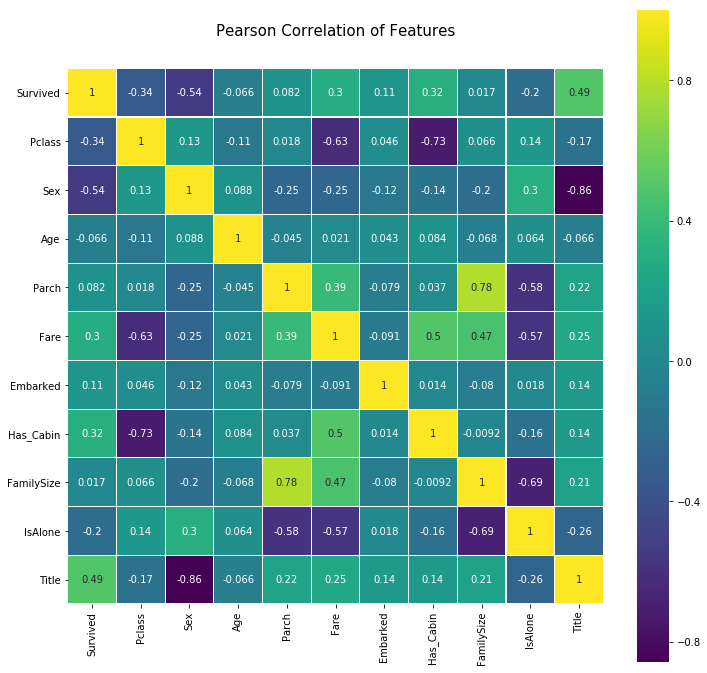

In [6]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [7]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [9]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [10]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [11]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [12]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [13]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [14]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [15]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [16]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [17]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [18]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

In [19]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.818165
         5          0.822672
         6          0.816005
         7          0.809238
         8          0.809238
         9          0.818227
        10          0.815993


In [22]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

In [31]:
x_train

array([[3, 1, 1, ..., 2, 0, 1],
       [1, 0, 2, ..., 2, 0, 3],
       [3, 0, 1, ..., 1, 1, 4],
       ...,
       [3, 0, 1, ..., 4, 0, 4],
       [1, 1, 1, ..., 1, 1, 1],
       [3, 1, 1, ..., 1, 1, 1]])

In [32]:
y_train.head(10)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

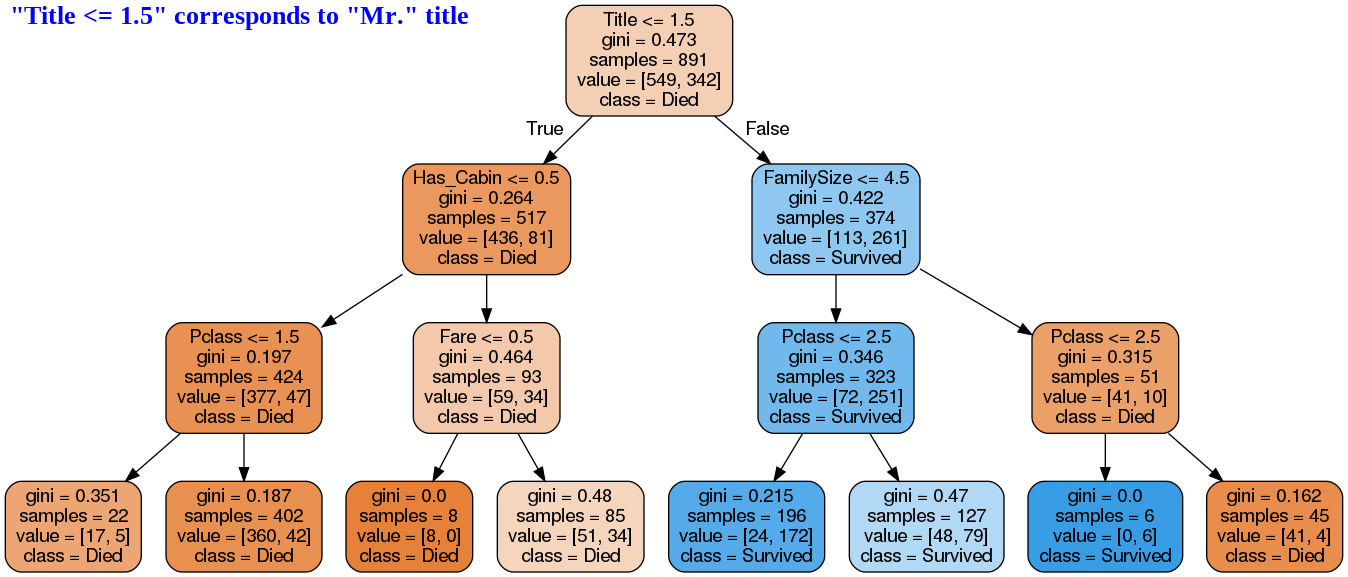

In [27]:
# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

# Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')